In [3]:
import cv2
import imutils
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt


import os

In [13]:
"""
image_path = "../results/predicted_images/predictions_3/"
img = os.path.join(image_path, "002_3.jpg")
"""

img = r"C:\Users\pedri\Desktop\real_pred.jpg"
actual_path = r"C:\Users\pedri\Desktop\drone_pic.png"

img

'C:\\Users\\pedri\\Desktop\\real_pred.jpg'

In [42]:
H = 320
W = 480

x = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
y = cv2.imread(actual_path, cv2.IMREAD_COLOR)

y = cv2.resize(y, (W, H))

print(type(y))



labels = ["paved-area",
        "dirt",
        "grass",
        "gravel",
        "water",
        "rocks",
        "pool",
        "vegetation",
        "roof",
        "wall",
        "window",
        "door",
        "fence",
        "fence-pole",
        "person",
        "dog",
        "car",
        "bicycle",
        "tree",
        "bald-tree",
        "ar-marker",
        "obstacle",
        "conflicting",
]
div = round(255 / len(labels))
thresh = [(1 + div*i, (i + 1)*div) for i in range(len(labels))]
new_list = zip(thresh, labels)


thresh_tuple = [cv2.threshold(x, thresh[i][0], thresh[i][1], cv2.THRESH_BINARY) for i in range(len(thresh))]


mask = [cv2.bitwise_and(x, x, mask = thresh_tuple[i][1]) for i in range(len(thresh_tuple))]
mask = [cv2.erode(mask[i], None, iterations = 2) for i in range(len(mask))]
mask = [cv2.dilate(mask[i], None, iterations = 2) for i in range(len(mask))]
mask = [mask[i].astype(np.uint8) for i in range(len(mask))]
#mask = [cv2.cvtColor(mask[i], cv2.COLOR_BGR2GRAY) for i in range(len(mask))]




<class 'numpy.ndarray'>


In [43]:
for i in range(len(mask)):
    cnts = cv2.findContours(mask[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None
    cX = None
    cY = None
    min_size = 20

    print(len(cnts))

    for c in cnts:
        ((cx, cy), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        (cX, cY) = center
        
        if radius > min_size:
            text = f"{labels[i]}"
            y = cv2.putText(img = y, 
                            text = text, 
                            org = (cX, cY - 15),
                            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale = 0.5, 
                            color = (255, 255, 255), 
                            thickness = 2)


1


TypeError: '>' not supported between instances of 'float' and 'tuple'

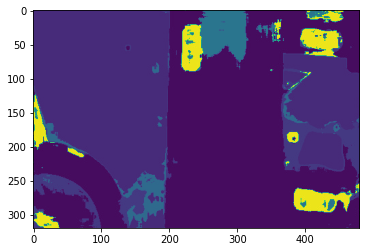

In [40]:

plt.figure()
plt.imshow(x)


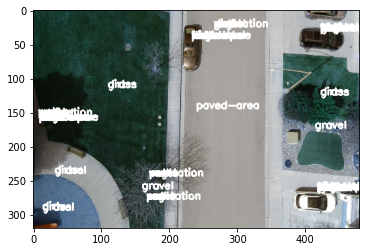

In [41]:
plt.figure()
plt.imshow(y)


TypeError: Input z must be 2D, not 3D

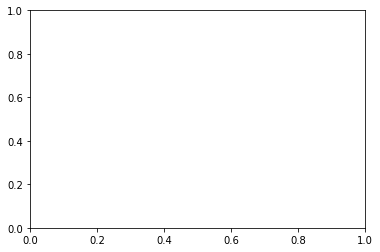

In [22]:
plt.figure()
plt.contourf(x)
plt.colorbar(label="Labels")

# Make Predictions on our own dataset

In [15]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import os


# Show GPUs devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4362814742952989332
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2956368283
locality {
  bus_id: 1
  links {
  }
}
incarnation: 940421028539062863
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [16]:
image_path = "../data/"
img = os.path.join(image_path, "drone_pic.PNG")
H = 320
W = 480
x = cv2.imread(img, cv2.IMREAD_COLOR)
x = cv2.resize(x, (W, H))
x = x/255.0
x = x.astype(np.float32)
plt.figure()
plt.imshow(x)
plt.colorbar(label="Labels")

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [15]:
# Load Model
model = tf.keras.models.load_model("../results/models/model_3.h5")

In [29]:
p = model.predict(np.expand_dims(x, axis=0))[0]


In [ ]:
p = np.argmax(p, axis=-1)
p = np.expand_dims(p, axis=-1)  
num_classes = 23
p = p * (255/num_classes)
p = p.astype(np.int32)
p = np.concatenate([p, p, p], axis=2)

In [24]:
cv2.imwrite(f"../results/real_pred.jpg", p)

True

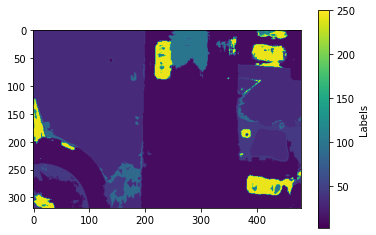

In [25]:
pred = cv2.imread("../results/real_pred.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(pred)
plt.colorbar(label="Labels")

In [28]:
p.shape

(320, 480, 3)

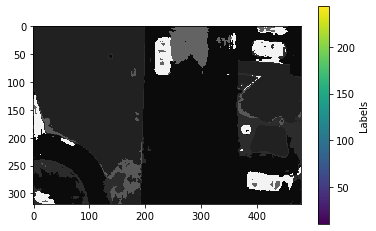

In [23]:
plt.imshow(p, interpolation = 'nearest')
plt.colorbar(label="Labels")